In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

class SurrogateLossLearner:
    def __init__(self):
        pass
    def predict(self, df, household_idx):
        # Line1
        df = self._prior(df, household_idx)
        print("line1 done")

        # Line2
        scores = []
        params = [mex_depth for mex_depth in range(2, 100, 5)]
        models = []
        for param in params:
            score = self._cv(df, param)
            scores.append(score)
        print("line2 done")
        # Line3
        best_idx = np.argmin(scores)
        best_model = DecisionTreeClassifier(max_depth=params[best_idx])
        best_model.fit(df.Energy.values.reshape(-1, 1), df.preds_time)
        print("line3 done")
        # Line4, 5
        preds_new = best_model.predict(df.Energy.values.reshape(-1, 1))
        df["preds_new"] = preds_new
        print("line4,5 done")
        return df


    def _cv(self, df, param):
        kf = KFold(n_splits=5, random_state=0, shuffle=True)
        losses = []
        for train_idx, test_idx in kf.split(df):
            # split data into train, test

            train_x, test_x = df.Energy.values[train_idx], df.Energy.values[test_idx]
            # TODO: whether or not use Energy only?
            train_y, test_y = df.preds_time.values[train_idx], df.preds_time.values[test_idx]

            # training
            model_energy = DecisionTreeClassifier(max_depth=param)
            model_energy.fit(train_x.reshape(-1, 1), train_y)
            # test
            preds = model_energy.predict_proba(test_x.reshape(-1, 1))
            preds = preds[:, 1]
            # Loss
            loss = self._surrogate_loss(test_y, preds)
            losses.append(loss)
        return np.mean(losses)
    def _surrogate_loss(self, y, preds):
        raw_neg = sum(y[preds==0]==1)/preds.shape[0]
        raw_pos = sum(y[preds==1]==0)/preds.shape[0]
        det = 1-raw_pos-raw_neg

        conditional_noise_rate_neg = (1-sum(y[preds==1]==1)/preds.shape[0]+sum(y[preds==0]==0)/preds.shape[0])/2
        loss_pos = log_loss(y, preds)
        conditional_noise_rate = (1-raw_pos+raw_neg)/2
        loss_neg = log_loss(abs(-y), preds)
        num = (1-conditional_noise_rate_neg)*loss_pos-conditional_noise_rate*loss_neg
        return num / det

    def _prior(self, df, household_idx=1):
        if household_idx in [2, 4, 5]:
            preds_time = []
            for _, row in df.iterrows():
                if (row.Time >= 18) & (row.Time <= 40):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        elif household_idx in [1, 3]:
            preds_time = []
            for _, row in df.iterrows():
                if (row["Time"] >= 24) & (row["Time"] <= 28):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        return df

In [4]:
import pandas as pd
target_idx = 3
summer_idx = 0
target_X = pd.read_csv(f"../../../deep_occupancy_detection/data/{target_idx}_X_train.csv")
target_y_task = pd.read_csv(f"../../../deep_occupancy_detection/data/{target_idx}_Y_train.csv")[target_X.Season==summer_idx]
target_X = target_X[target_X.Season==summer_idx]
target_X["Time"] = [i for i in range(12, 44, 1)]*int(target_X.shape[0]/32)

In [5]:
surrogate_leaner = SurrogateLossLearner()
new_df = surrogate_leaner.predict(df=target_X, household_idx=target_idx)

line1 done


line2 done
line3 done
line4,5 done


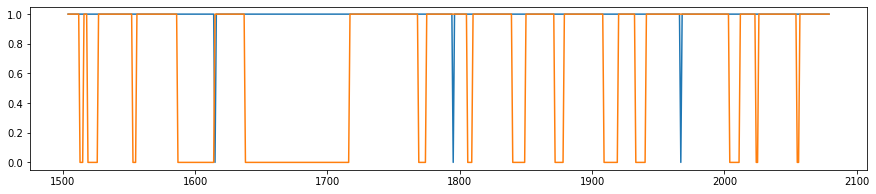

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 3))
plt.plot(new_df["preds_new"])
plt.plot(target_y_task)

In [7]:
sum(new_df["preds_new"].values.reshape(-1) == target_y_task.Occupancy.values.reshape(-1))/new_df.shape[0]

0.6840277777777778